# Gold Price Prediction with Logistic Regression

## Problem Description
#### This project attempts to predict the price of gold using the OHLCV data and technical indicators from the gold ETF "GLD" to build a logitic regression model.  The ETF "GLD" mirrors gold price in price movement.  The ultimate goal is to develop a trading strategy that can generate consistent profits over time, while managing risk and minimizing losses.

#### Github: https://github.com/AndrewFSee/CU-Projects

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')
import seaborn as sns
import matplotlib.colors as clrs
import talib as ta
from statsmodels.tsa.stattools import adfuller
import yfinance as yf
import datetime
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

C:\Users\asee\AppData\Local\Temp\ipykernel_8320\596378225.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


In [2]:
#set ticker symbol and start/end dates
ticker = 'GLD'
start_date = datetime.datetime.now() - datetime.timedelta(days=10080)
end_date = datetime.date.today()

In [3]:
#pull data from yfinance
df = yf.download(ticker, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


#### Data downloaded using the yahoo finance api
#### Yahoo Finance(2023).  Historical stock prices.  Retrieved from https://finance.yahoo.com/quote/GLD/
#### Data begins on 2004-11-18 and ends on 2023-04-27 and includes the Open, High, Low, Close, Adj Close, and Volume for GLD.

In [4]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-11-18,44.430000,44.490002,44.070000,44.380001,44.380001,5992000
2004-11-19,44.490002,44.919998,44.470001,44.779999,44.779999,11655300
2004-11-22,44.750000,44.970001,44.740002,44.950001,44.950001,11996000
2004-11-23,44.880001,44.919998,44.720001,44.750000,44.750000,3169200
2004-11-24,44.930000,45.049999,44.790001,45.049999,45.049999,6105100


In [5]:
# Count the number of NA values in the DataFrame
na_count = df.isna().sum().sum()

# Print the number of NA values
print("The dataset contains", na_count, "NA values.")

The dataset contains 0 NA values.


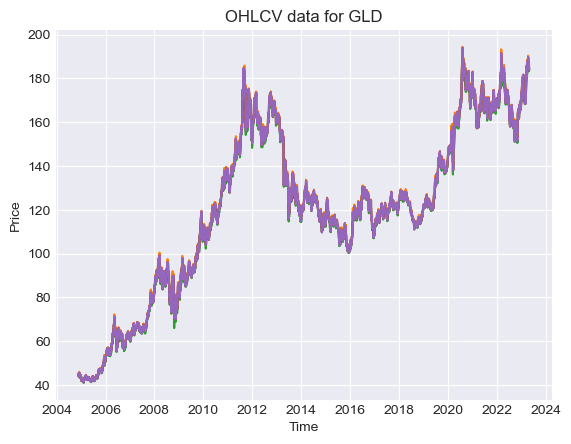

In [6]:
plt.plot(df[['Open', 'High', 'Low', 'Close', 'Adj Close']])
plt.title('OHLCV data for GLD')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

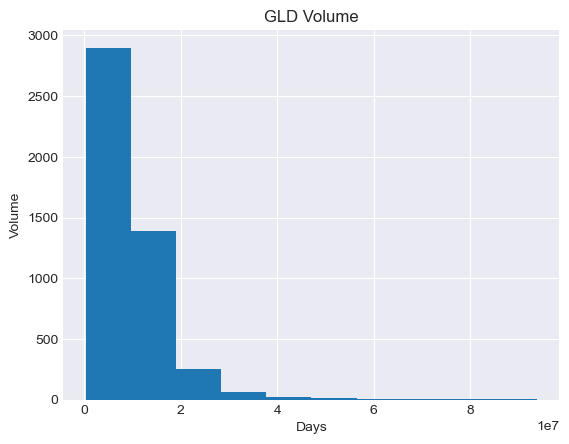

In [7]:
plt.hist(df['Volume'])
plt.title('GLD Volume')
plt.xlabel('Days')
plt.ylabel('Volume')
plt.show()

#### Dataset was checked for NA values and doesn't show any NA values.  Data was plotted to check for any inconsistencies and when looking at plots there doesn't seem to be any outlier data points that would seem to be incorrect.

## EDA

In [8]:
#create a column 'future returns' with the calculation of percentage change
df['future_returns'] = df['Adj Close'].pct_change().shift(-1)

#create the signal column
df['signal'] = np.where(df['future_returns'] > 0, 1, 0)

df.head()

,Open,High,Low,Close,Adj Close,Volume,future_returns,signal
Date,,,,,,,,
2004-11-18,44.430000,44.490002,44.070000,44.380001,44.380001,5992000,0.009013,1
2004-11-19,44.490002,44.919998,44.470001,44.779999,44.779999,11655300,0.003796,1
2004-11-22,44.750000,44.970001,44.740002,44.950001,44.950001,11996000,-0.004449,0
2004-11-23,44.880001,44.919998,44.720001,44.750000,44.750000,3169200,0.006704,1
2004-11-24,44.930000,45.049999,44.790001,45.049999,45.049999,6105100,0.005327,1


#### A future returns column was created by shifting the data one day ahead and calculated the percent change.  A signal column was then created using the future returns so that a signal of 1 (buy) or 0 (sell) were generated.

In [9]:
#create a column 'pct_change' with the daily change
df['pct_change'] = df['Adj Close'].pct_change()

#create a column 'pct_change_week' with the 5 day percentage change
df['pct_change_week'] = df['Adj Close'].pct_change(5)

#create a column 'pct_change_month' with the monthly percentage change
df['pct_change_month'] = df['Adj Close'].pct_change(21)

In [10]:
#create RSI column
df['rsi'] = ta.RSI(df['Adj Close'].values, timeperiod=14)

#create ADX column
df['adx'] = ta.ADX(df['High'], df['Low'], df['Adj Close'], timeperiod=14)

#create MACD column
df['macd'], df['macdsignal'], df['macdhist'] = ta.MACD(df['Adj Close'], fastperiod=12, slowperiod=26, 
                                                       signalperiod = 9)

#create MFI column
df['mfi'] = ta.MFI(df['High'], df['Low'], df['Adj Close'], df['Volume'], timeperiod=14)

#create stoch column
df['slowk'], df['slowd'] = ta.STOCH(df['High'], df['Low'], df['Adj Close'], fastk_period=5, slowk_period=3,
                                   slowk_matype=0, slowd_period=3, slowd_matype=0)

#create stoch fast column
df['fastk'], df['fastd'] = ta.STOCHF(df['High'], df['Low'], df['Adj Close'], fastk_period=5, fastd_period=3,
                                   fastd_matype=0)

#create willr column
df['willr'] = ta.WILLR(df['High'], df['Low'], df['Close'], timeperiod=14)

In [11]:
#create 5 day MA
df['sma5'] = df['Adj Close'].rolling(window=5).mean()

#create 5 day correlation
df['corr5'] = df['Adj Close'].rolling(window=5).corr(df['sma5'])

#create 20 day MA
df['sma20'] = df['Adj Close'].rolling(window=20).mean()

#create 20 day correlation
df['corr20'] = df['Adj Close'].rolling(window=20).corr(df['sma20'])

#create 50 day MA
df['sma50'] = df['Adj Close'].rolling(window=50).mean()

#create 50 day correlation
df['corr50'] = df['Adj Close'].rolling(window=50).corr(df['sma50'])

In [12]:
#create 5 day volatility
df['volatility5'] = df.rolling(5, min_periods=5)['pct_change'].std()*100

#create 20 day volatility
df['volatility20'] = df.rolling(20, min_periods=20)['pct_change'].std()*100

#create 50 day volatility
df['volatility50'] = df.rolling(50, min_periods=50)['pct_change'].std()*100

#### Generated additional features using python functions and ta-lib library.

In [13]:
df.dropna(inplace=True)

In [14]:
#create target and features
y = df[['signal']].copy()

X = df[['Volume', 'pct_change', 'pct_change_week', 'pct_change_month', 'rsi', 'adx', 'macd', 'mfi', 
        'macdsignal', 'mfi', 'slowk', 'slowd', 'fastk', 'fastd', 'willr', 'sma5', 'corr5', 'sma20', 
        'corr20', 'sma50', 'corr50', 'volatility5', 'volatility20', 'volatility50']].copy()

#### Created the target to predict and features datasets.

In [15]:
def stationary(series):
    """Function to check if the series is stationary or not.
    """

    result = adfuller(series)
    if(result[1] < 0.05):
        return 'stationary'
    else:
        return 'not stationary'


In [16]:
# Check for stationarity
for col in X.columns:
    if stationary(df[col]) == 'not stationary':
        print('%s is not stationary. Dropping it.' % col)
        X.drop(columns=[col], axis=1, inplace=True)
    else:
        print('%s is stationary.' % col)

Volume is stationary.
pct_change is stationary.
pct_change_week is stationary.
pct_change_month is stationary.
rsi is stationary.
adx is stationary.
macd is stationary.
mfi is stationary.
macdsignal is stationary.
mfi is stationary.
slowk is stationary.
slowd is stationary.
fastk is stationary.
fastd is stationary.
willr is stationary.
sma5 is not stationary. Dropping it.
corr5 is stationary.
sma20 is not stationary. Dropping it.
corr20 is stationary.
sma50 is not stationary. Dropping it.
corr50 is stationary.
volatility5 is stationary.
volatility20 is stationary.
volatility50 is stationary.


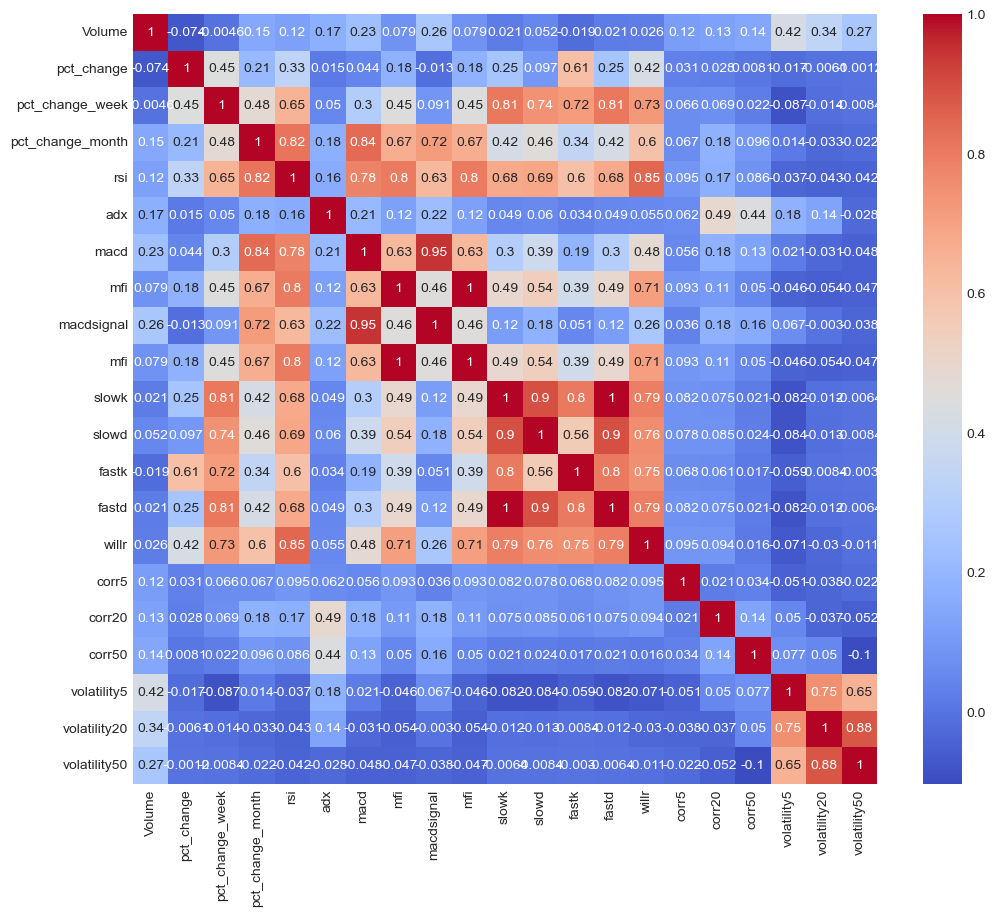

In [17]:
# Compute the correlation matrix
corr = X.corr()

# Create a heatmap
plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap='coolwarm', annot=True)

# Show the plot
plt.show()

In [18]:
def get_pair_above_threshold(X, threshold):
    """Function to return the pairs with correlation above threshold.
    """
    # Calculate the correlation matrix
    correl = X.corr()

    # Unstack the matrix
    correl = correl.abs().unstack()

    # Recurring & redundant pair
    pairs_to_drop = set()
    cols = X.corr().columns
    for i in range(0, X.corr().shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))

    # Drop the recurring & redundant pair
    correl = correl.drop(labels=pairs_to_drop).sort_values(ascending=False)

    return correl[correl > threshold].index

In [19]:
print(get_pair_above_threshold(X, 0.8))

MultiIndex([(           'slowk',        'fastd'),
            (            'macd',   'macdsignal'),
            (           'slowd',        'fastd'),
            (           'slowk',        'slowd'),
            (    'volatility20', 'volatility50'),
            (             'rsi',        'willr'),
            ('pct_change_month',         'macd'),
            ('pct_change_month',          'rsi'),
            ( 'pct_change_week',        'fastd'),
            ( 'pct_change_week',        'slowk'),
            (           'slowk',        'fastk'),
            (           'fastk',        'fastd'),
            (             'rsi',          'mfi'),
            (             'rsi',          'mfi')],
           )


In [20]:
#drop highly correlated columns
X = X.drop(columns=['volatility20', 'mfi', 'willr', 'macdsignal', 'fastd', 'slowk', 'pct_change_month'])

#### Removed non-stationary and highly correlated features.

In [21]:
X.shape

(4543, 13)

In [22]:
# Obtain the features and target for the `train_data` and `test_data` without shuffling
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.80, shuffle=False)

In [23]:
# Print the dimensions of the variables
print(f"The shape of the X variable is {X.shape}.")
print(f"The shape of the y variable is {y.shape}. \n")
print(f"The shape of the X_train variable is {X_train.shape}.")
print(f"The shape of the y_train variable is {y_train.shape}.\n")
print(f"The shape of the X_test variable is {X_test.shape}.")
print(f"The shape of the y_test variable is {y_test.shape}.\n")

The shape of the X variable is (4543, 13).
The shape of the y variable is (4543, 1). 

The shape of the X_train variable is (3634, 13).
The shape of the y_train variable is (3634, 1).

The shape of the X_test variable is (909, 13).
The shape of the y_test variable is (909, 1).



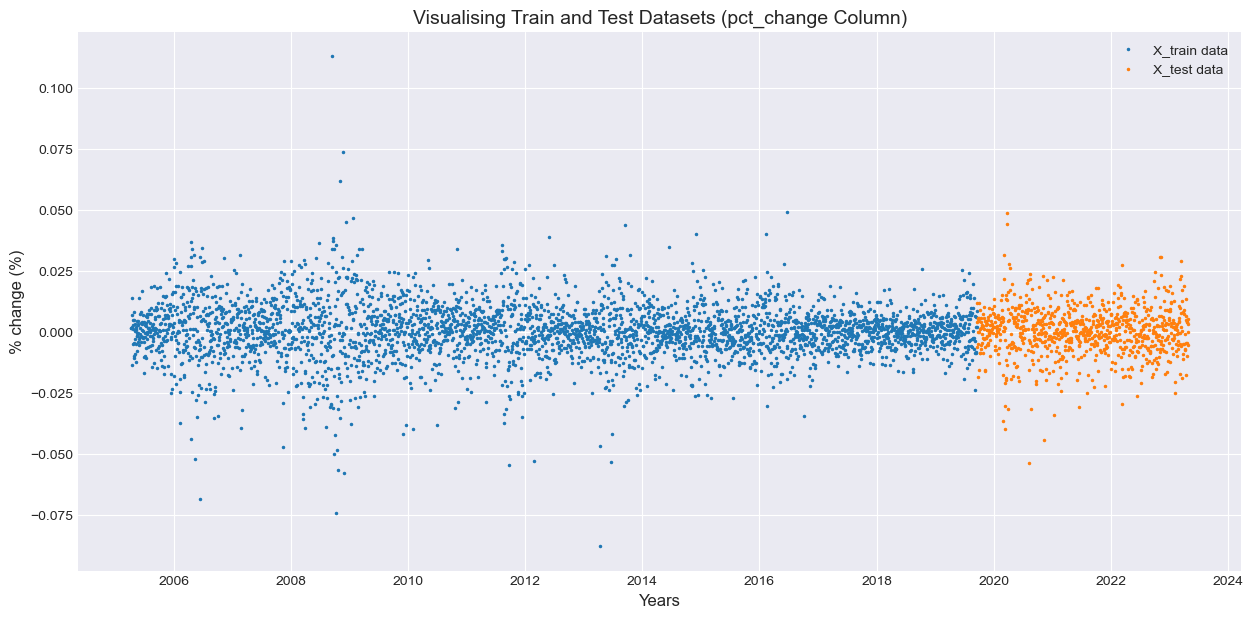

In [24]:
# Plot the data
plt.figure(figsize=(15, 7))

plt.plot(X_train['pct_change'], linestyle='None',
         marker='.', markersize=3.0, label='X_train data')
plt.plot(X_test['pct_change'], linestyle='None',
         marker='.', markersize=3.0, label='X_test data')

# Set the title and axis label
plt.title("Visualising Train and Test Datasets (pct_change Column)", fontsize=14)
plt.xlabel('Years', fontsize=12)
plt.ylabel('% change (%)', fontsize=12)

# Display the plot
plt.legend()
plt.show()

#### Split the data into 80% training set and 20% test set.  The data was split with shuffle set to false so that the newest data would be tested.

## Model

In [25]:
# Create the machine learning model
lr_model = LogisticRegression(fit_intercept=True)

In [26]:
hyperparameters = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

In [27]:
grid_search = GridSearchCV(lr_model, hyperparameters, cv=5)

In [28]:
pca = PCA(n_components=13)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

#### To address multicollinearity the dimensionality of the features were reduced using PCA.

In [29]:
lr_model = grid_search.fit(X_train_pca, y_train['signal'])

In [30]:
print("Best hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best hyperparameters:  {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Best score:  0.4989079238047601


#### Created the LR model then ran a gridsearch using a range of hyperparameters.  

In [31]:
# Get a sample day of data from X_test
unseen_data_single_day = X_test.head(1)

# Preview the data
unseen_data_single_day

,Volume,pct_change,pct_change_week,rsi,adx,macd,slowd,fastk,corr5,corr20,corr50,volatility5,volatility50
Date,,,,,,,,,,,,,
2019-09-18,15026300,-0.006285,-0.002269,47.668022,18.663777,0.267796,32.07546,27.35583,0.507143,-0.190763,0.835213,0.67998,0.978538


In [32]:
# Use the model and predict the values for the test data
y_pred = lr_model.predict(X_test)

C:\Users\asee\Anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [33]:
y_test

,signal
Date,
2019-09-18,1
2019-09-19,1
2019-09-20,1
2019-09-23,1
2019-09-24,0
...,...
2023-04-21,1
2023-04-24,1
2023-04-25,0


In [34]:
y_test_signal = y_test['signal']

## Results and Analysis

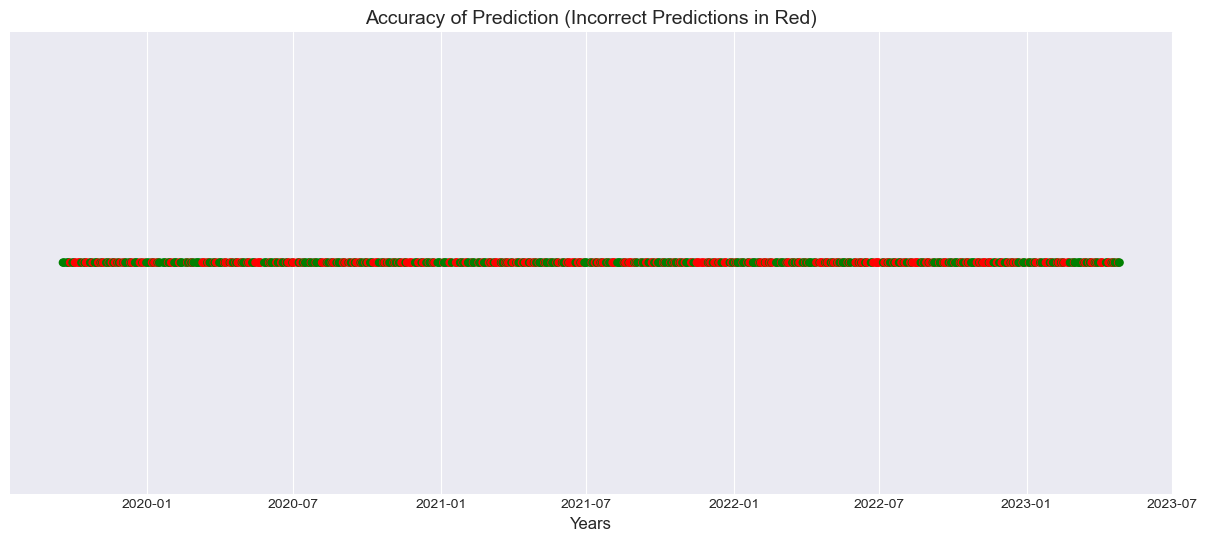

The accuracy is 54.02%.


In [35]:
# Define the accuracy data

accuracy_data = (y_pred == y_test_signal)

# Accuracy percentage
accuracy_percentage = round(100 * accuracy_data.sum()/len(accuracy_data), 2)

# Plot the accuracy data
plt.figure(figsize=(15, 6))

# Colour mapping for the correct and incorrect predictions
cmap = clrs.ListedColormap(['green', 'red'])

plt.yticks([])
plt.scatter(x=y_test.index, y=[1]*len(y_test),
            c=(accuracy_data != True).astype(float), marker='.', cmap=cmap, s = 100)

# Set the title and axis label
plt.title("Accuracy of Prediction (Incorrect Predictions in Red)", fontsize=14)
plt.xlabel('Years', fontsize=12)

# Display the results
plt.show()
print(f"The accuracy is {accuracy_percentage}%.")

#### The accuracy of the model is only 54.02% which is a bit low.  However, the real results will come from back-testing a strategy based on the model.

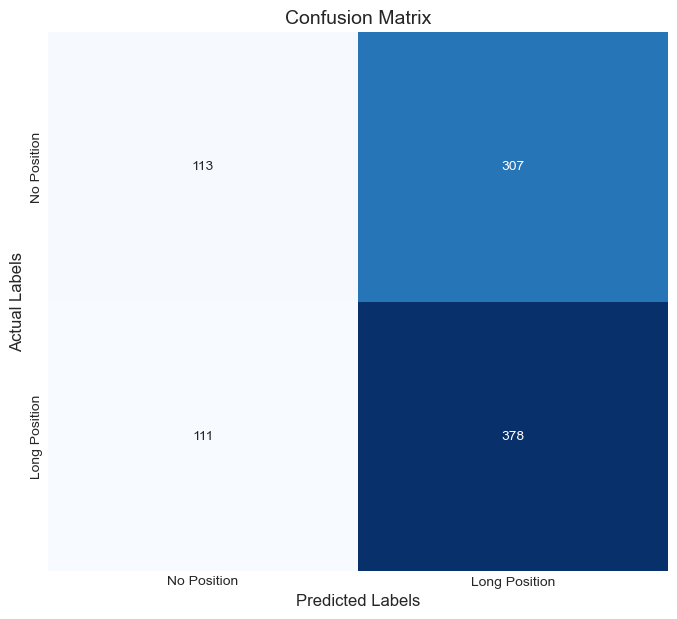

In [45]:
# Define the confusion matrix
confusion_matrix_data = confusion_matrix(y_test, y_pred)

# Plot the data
fig, ax = plt.subplots(figsize=(8, 7))
sns.heatmap(confusion_matrix_data, fmt="d",
            cmap='Blues', cbar=False, annot=True, ax=ax)

# Set the axes labels and the title
ax.set_xlabel('Predicted Labels', fontsize=12)
ax.set_ylabel('Actual Labels', fontsize=12)
ax.set_title('Confusion Matrix', fontsize=14)
ax.xaxis.set_ticklabels(['No Position', 'Long Position'])
ax.yaxis.set_ticklabels(['No Position', 'Long Position'])

# Display the plot
plt.show()

In [36]:
# Classification report
classification_report_data = classification_report(y_test, y_pred)

# Print the classification report
print(classification_report_data)

              precision    recall  f1-score   support

           0       0.50      0.27      0.35       420
           1       0.55      0.77      0.64       489

    accuracy                           0.54       909
   macro avg       0.53      0.52      0.50       909
weighted avg       0.53      0.54      0.51       909



#### Looking at some other evaluation metrics such as precision, recall, and f1-score don't show the greatest results either.

In [37]:
#create dataframe for strategy backtest
strategy_data = pd.DataFrame(y_pred, index=y_test.index, columns=['signal'])
strategy_data['close'] = df['Adj Close']

The return is 23.84%.


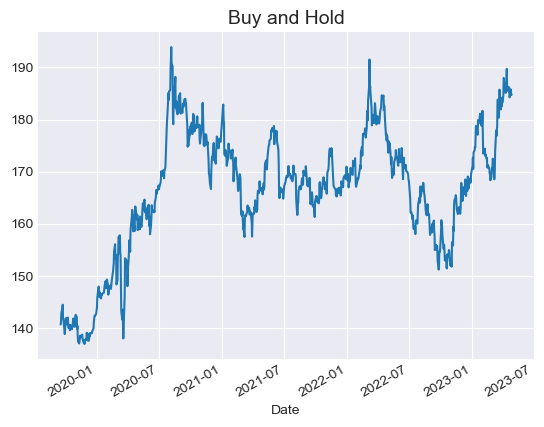

In [38]:
plt.title('Buy and Hold', fontsize=14)
strategy_data['close'].plot()
buyandhold = (1 - strategy_data['close'][0]/strategy_data['close'][-1])*100
print("The return is {0:.2f}%.".format(buyandhold))

#### A strategy of "Buy and Hold" will serve as the benchmark to compare the strategy of buying and selling using the model.  We can see that "Buy and Hold" yields a return of 23.84% using the test data.

In [39]:
# Calculate the percentage change
strategy_data['pct_change'] = strategy_data['close'].pct_change()

# Calculate the strategy returns
strategy_data['strategy_returns'] = strategy_data['signal'].shift(1) * strategy_data['pct_change']

# Drop the missing values
strategy_data.dropna(inplace=True)

strategy_data.head()

,signal,close,pct_change,strategy_returns
Date,,,,
2019-09-19,1,141.279999,0.004051,0.004051
2019-09-20,1,142.949997,0.011820,0.011820
2019-09-23,1,143.750000,0.005596,0.005596
2019-09-24,0,144.509995,0.005287,0.005287
2019-09-25,0,141.830002,-0.018545,-0.000000


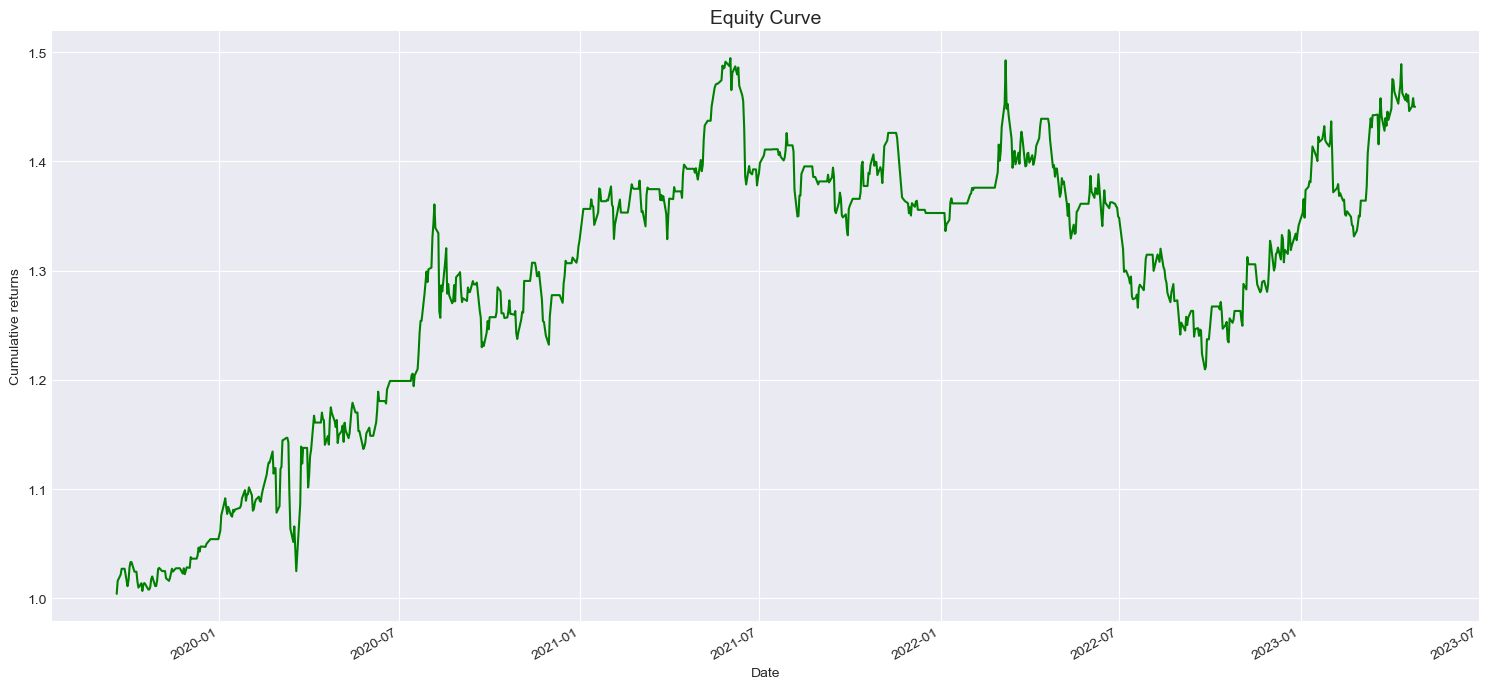

The cumulative return is 45.00%.


In [40]:
# Calculate the cumulative returns
strategy_data['cumulative_returns'] = (1+strategy_data['strategy_returns']).cumprod()

# ---------------------Equity Curve---------------------
# Plot cumulative strategy returns
strategy_data['cumulative_returns'].plot(figsize=(15, 7), color='green')
plt.title('Equity Curve', fontsize=14)
plt.ylabel('Cumulative returns')
plt.tight_layout()
plt.show()

cumulative_returns = (strategy_data['cumulative_returns'][-1] - 1)*100
print("The cumulative return is {0:.2f}%.".format(cumulative_returns))

#### After creating a strategy dataset, the cumulative returns using the model based strategy were calcluated and plotted.  The cumulative returns at the end of the test data period were 45.00%.  This is an improvement of ~21% over the "Buy and Hold" benchmark strategy!

In [41]:
# Calculate the annualised returns
annualised_return = ((strategy_data['cumulative_returns'][-1]) **
                    (252/strategy_data.shape[0]) - 1) * 100
print("The annualised return is {0:.2f}%.".format(annualised_return))

The annualised return is 10.86%.


In [42]:
# Calculate the annualised volatility
annualised_volatility = strategy_data['strategy_returns'].std()*np.sqrt(
    252) * 100
print("The annualised volatility is {0:.2f}%.".format(annualised_volatility))

The annualised volatility is 14.13%.


#### The annualised return of the model strategy is 10.86%.  These are decent but not the greatest returns however the annualised returns of the S&P 500 are only about 7% on average.  Gold is generally considered to be a safe-haven asset so getting better returns than the stock market on a less risky asset may be very desirable to some investors.
#### The annualised volatility of the model strategy is 14.13% which is high, but this volatility could be leveraged using a good risk management strategy.

The maximum drawdown is -19.07%.


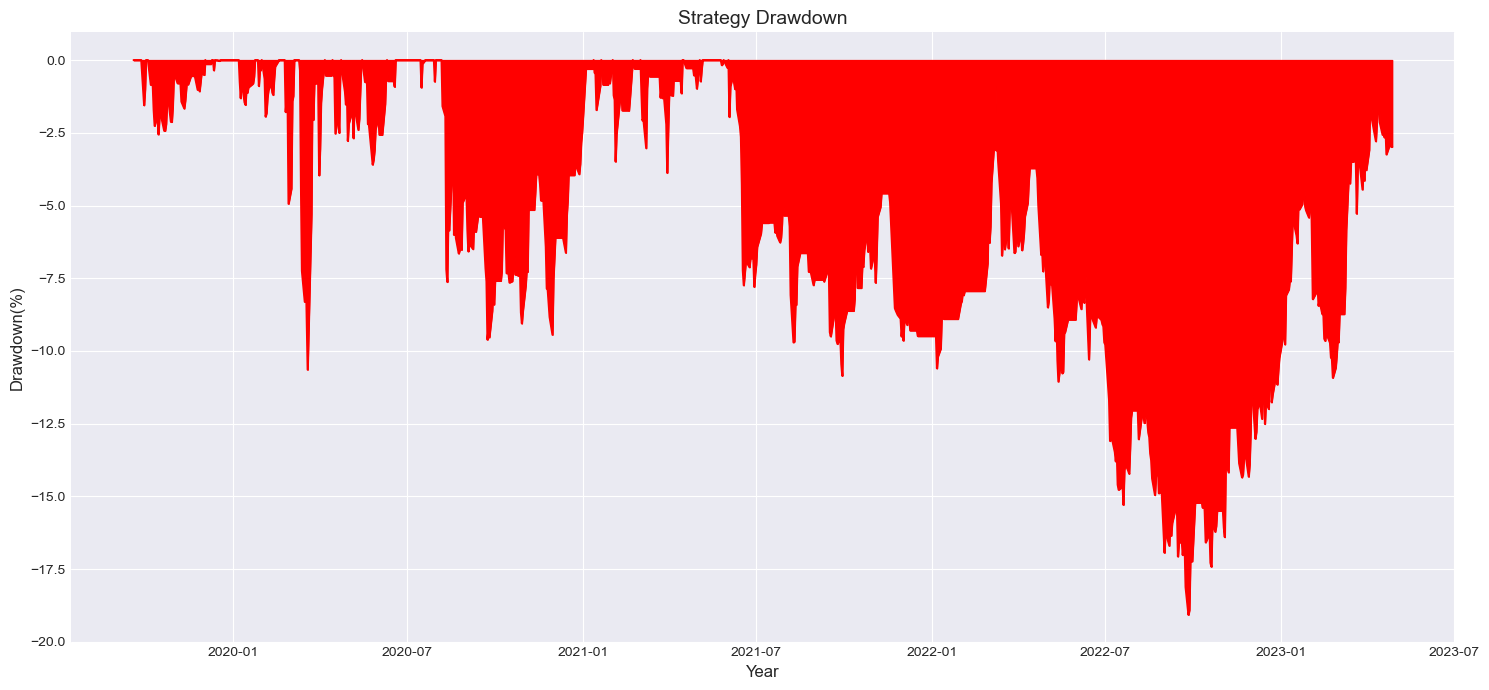

In [43]:
# Calculate the running maximum
running_max = np.maximum.accumulate(
    strategy_data['cumulative_returns'].dropna())
# Ensure the value never drops below 1
running_max[running_max < 1] = 1
# Calculate the percentage drawdown
drawdown = ((strategy_data['cumulative_returns'])/running_max - 1) * 100

# Calculate the maximum drawdown
max_dd = drawdown.min()
print("The maximum drawdown is {0:.2f}%.".format(max_dd))

# ---------------------DD plot---------------------
fig = plt.figure(figsize=(15, 7))

# Plot max drawdown
plt.plot(drawdown, color='red')
# Fill in-between the drawdown
plt.fill_between(drawdown.index, drawdown.values, color='red')
plt.title('Strategy Drawdown', fontsize=14)
plt.ylabel('Drawdown(%)', fontsize=12)
plt.xlabel('Year', fontsize=12)

plt.tight_layout()
plt.show()

In [44]:
# Calculate the Sharpe ratio
sharpe_ratio = round(strategy_data['strategy_returns'].mean() /
                     strategy_data['strategy_returns'].std() * np.sqrt(252), 2)
print("The Sharpe ratio is {0:.2f}.".format(sharpe_ratio))

The Sharpe ratio is 0.80.


#### The maximum drawdown using the model strategy is -19.07% which is the largest percentage decrease between the peak and subsequent trough.  This could be avoided with some risk management and domain knowledge.  The sharpe ratio using the model strategy is 0.80 which is a bit low and is ideally 1.0 or above.

## Discussion/Conclusion
#### The strategy using the model shows an improvement over the benchmark of "buy and hold" by ~21% during the backtest over the test data time period.  So even though the accuracy was only 54.02% that extra 4.02% over correctly guessing only 50% of the time does add up in real returns!.  Model accuracy could probably be increased as it seems that technical data doesn't fully explain the movement in the price.  A NLP model might further increase predictive power using news data.  Combining this strategy with a good risk management strategy such as using support and resistance levels could potentially reduce some of those nasty drawdowns and increase returns.  Running this model as a strategy is not recommended before doing some live testing by building a trading bot and letting it run with a paper account for at least 6 months.  The strategy using the model shows promise and could play a part in a more diverse strategy.